# Introduction to Bayesian Neural Networks

### Author: [Dr. Rahul Remanan](https://www.linkedin.com/in/rahulremanan/)
### [CEO, Moad Computer](https://moad.computer)
Learn basics of building Bayesian neural networks using Tensorflow, Keras and Tensorflow Probability.

## [Run this notebook in Google Colab](https://colab.research.google.com/github/rahulremanan/python_tutorial/blob/master/Machine_Vision/07_Bayesian_deep_learning/notebook/Introduction_to_Bayesian_neural_networks.ipynb)

# Import dependent libraries

In [2]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as tfk
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

from tqdm import tqdm
from matplotlib import figure 
from matplotlib.backends import backend_agg
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Part 01 -- Air quality prediction
Predict the groundtruth air pollutant levels using estimated values from a set of metal oxide sensors.


#### [More about the dataset](http://archive.ics.uci.edu/ml/datasets/Air+Quality)

In [2]:
tf.keras.backend.set_floatx("float64")

In [3]:
tfk=tf.keras
tfd=tfp.distributions

In [4]:
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000,
                           behaviour="deprecated",
                           contamination="auto",
                           random_state=0)
neg_log_likelihood=lambda x,rv_x:-rv_x.log_prob(x)

In [5]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
!unzip -q ./Air*.zip

--2020-09-06 14:32:00--  http://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1543989 (1.5M) [application/x-httpd-php]
Saving to: ‘AirQualityUCI.zip.1’

AirQualityUCI.zip.1 100%[===================>]   1.47M  1.48MB/s    in 1.0s    

2020-09-06 14:32:02 (1.48 MB/s) - ‘AirQualityUCI.zip.1’ saved [1543989/1543989]

replace AirQualityUCI.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
data=pd.read_excel('/content/AirQualityUCI.xlsx')
data=data[data['Date']<='2004-09-10']

In [7]:
columns=['PT08.S1(CO)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)','T','AH','CO(GT)','C6H6(GT)','NOx(GT)','NO2(GT)']
data=data[columns].dropna(axis=0)

In [8]:
X_t=scaler.fit_transform(data)

In [9]:
is_inlier=detector.fit_predict(X_t)
X_t=X_t[(is_inlier > 0),:]

In [10]:
dataset=pd.DataFrame(X_t,columns=columns)

In [11]:
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

In [12]:
n_epochs = 50
n_samples = dataset.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

In [13]:
n_train = int(0.7*dataset.shape[0])

In [14]:
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

In [15]:
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)

In [16]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), 
                                                dtype=tf.float64), 
                                   scale=1.0), 
                        reinterpreted_batch_ndims=1)


In [17]:
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfk.layers.Dense(10, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [18]:
model.compile(optimizer="adam", loss=neg_log_likelihood)

In [19]:
model.fit(data_train, 
          epochs=n_epochs, 
          validation_data=data_test, 
          verbose=True)

Epoch 1/50
400/400 [==============================] - 47s 118ms/step - loss: 3.3744 - val_loss: 2.0970
Epoch 2/50
400/400 [==============================] - 40s 101ms/step - loss: 1.5857 - val_loss: 1.3709
Epoch 3/50
400/400 [==============================] - 41s 102ms/step - loss: 1.1588 - val_loss: 1.0087
Epoch 4/50
400/400 [==============================] - 41s 103ms/step - loss: 0.9786 - val_loss: 0.9299
Epoch 5/50
400/400 [==============================] - 40s 100ms/step - loss: 0.8955 - val_loss: 0.8415
Epoch 6/50
400/400 [==============================] - 40s 100ms/step - loss: 0.8734 - val_loss: 0.8169
Epoch 7/50
400/400 [==============================] - 40s 100ms/step - loss: 0.8411 - val_loss: 0.8073
Epoch 8/50
400/400 [==============================] - 40s 101ms/step - loss: 0.9138 - val_loss: 0.7829
Epoch 9/50
400/400 [==============================] - 40s 100ms/step - loss: 0.7853 - val_loss: 0.7442
Epoch 10/50
400/400 [==============================] - 40s 100ms/step - l

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                70        
_________________________________________________________________
distribution_weights (Dense) (None, 14)                154       
_________________________________________________________________
output (MultivariateNormalTr ((None, 4), (None, 4))    0         
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [21]:
tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

In [22]:
samples=500
iterations=10
test_iterator=iter(data_test)
(X_true,Y_true,Y_pred)=(np.empty(shape=(samples,len(inputs))),
                        np.empty(shape=(samples,len(outputs))),
                        np.empty(shape=(samples,len(outputs),iterations)))
for i in tqdm(range(samples)):
  features,labels=test_iterator.get_next()
  X_true[i,:]=features
  Y_true[i,:]=labels.numpy()
  for k in range(iterations):
    Y_pred[i,:,k]=model.predict(features)
  model.evaluate(features)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0087


  0%|          | 1/500 [00:01<08:57,  1.08s/it]

1/1 [==============================] - 0s 1ms/step - loss: 1.1096


  0%|          | 2/500 [00:01<07:21,  1.13it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1917


  1%|          | 3/500 [00:01<06:12,  1.33it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.9942


  1%|          | 4/500 [00:02<05:25,  1.52it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7600


  1%|          | 5/500 [00:02<04:52,  1.69it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0272


  1%|          | 6/500 [00:03<04:28,  1.84it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6794


  1%|▏         | 7/500 [00:03<04:10,  1.96it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.8412


  2%|▏         | 8/500 [00:04<03:58,  2.06it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9166


  2%|▏         | 9/500 [00:04<03:49,  2.14it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1284


  2%|▏         | 10/500 [00:04<03:42,  2.20it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9281


  2%|▏         | 11/500 [00:05<03:37,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.6680


  2%|▏         | 12/500 [00:05<03:34,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2818


  3%|▎         | 13/500 [00:06<03:31,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9866


  3%|▎         | 14/500 [00:06<03:28,  2.33it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5955


  3%|▎         | 15/500 [00:07<03:27,  2.34it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9804


  3%|▎         | 16/500 [00:07<03:25,  2.36it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9601


  3%|▎         | 17/500 [00:07<03:26,  2.34it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9938


  4%|▎         | 18/500 [00:08<03:26,  2.33it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.4477


  4%|▍         | 19/500 [00:08<03:25,  2.34it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.5785


  4%|▍         | 20/500 [00:09<03:25,  2.33it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6887


  4%|▍         | 21/500 [00:09<03:24,  2.34it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0202


  4%|▍         | 22/500 [00:10<03:25,  2.33it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9555


  5%|▍         | 23/500 [00:10<03:24,  2.33it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9099


  5%|▍         | 24/500 [00:10<03:23,  2.34it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1780


  5%|▌         | 25/500 [00:11<03:23,  2.34it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2163


  5%|▌         | 26/500 [00:11<03:23,  2.32it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7482


  5%|▌         | 27/500 [00:12<03:23,  2.33it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.6841


  6%|▌         | 28/500 [00:12<03:25,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6717


  6%|▌         | 29/500 [00:13<03:24,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9734


  6%|▌         | 30/500 [00:13<03:22,  2.32it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1751


  6%|▌         | 31/500 [00:13<03:21,  2.32it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0203


  6%|▋         | 32/500 [00:14<03:22,  2.31it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.4806


  7%|▋         | 33/500 [00:14<03:23,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7357


  7%|▋         | 34/500 [00:15<03:22,  2.30it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.9432


  7%|▋         | 35/500 [00:15<03:22,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.2245


  7%|▋         | 36/500 [00:16<03:21,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1656


  7%|▋         | 37/500 [00:16<03:19,  2.32it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1372


  8%|▊         | 38/500 [00:16<03:20,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.2913


  8%|▊         | 39/500 [00:17<03:20,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0729


  8%|▊         | 40/500 [00:17<03:19,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.4215


  8%|▊         | 41/500 [00:18<03:20,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6006


  8%|▊         | 42/500 [00:18<03:19,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2449


  9%|▊         | 43/500 [00:19<03:18,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.1975


  9%|▉         | 44/500 [00:19<03:16,  2.32it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7296


  9%|▉         | 45/500 [00:20<03:15,  2.33it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8989


  9%|▉         | 46/500 [00:20<03:16,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9379


  9%|▉         | 47/500 [00:20<03:15,  2.32it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1292


 10%|▉         | 48/500 [00:21<03:15,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0167


 10%|▉         | 49/500 [00:22<03:50,  1.95it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0168


 10%|█         | 50/500 [00:22<03:42,  2.02it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7785


 10%|█         | 51/500 [00:22<03:35,  2.09it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0192


 10%|█         | 52/500 [00:23<03:29,  2.14it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9738


 11%|█         | 53/500 [00:23<03:25,  2.18it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.1858


 11%|█         | 54/500 [00:24<03:23,  2.19it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9002


 11%|█         | 55/500 [00:24<03:23,  2.18it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0168


 11%|█         | 56/500 [00:25<03:19,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.1894


 11%|█▏        | 57/500 [00:25<03:15,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9891


 12%|█▏        | 58/500 [00:25<03:14,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8536


 12%|█▏        | 59/500 [00:26<03:13,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9293


 12%|█▏        | 60/500 [00:26<03:12,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7840


 12%|█▏        | 61/500 [00:27<03:12,  2.28it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.1382


 12%|█▏        | 62/500 [00:27<03:13,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2844


 13%|█▎        | 63/500 [00:28<03:12,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.5370


 13%|█▎        | 64/500 [00:28<03:10,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1862


 13%|█▎        | 65/500 [00:29<03:09,  2.30it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.9432


 13%|█▎        | 66/500 [00:29<03:09,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3525


 13%|█▎        | 67/500 [00:29<03:08,  2.30it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.0634


 14%|█▎        | 68/500 [00:30<03:07,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.8452


 14%|█▍        | 69/500 [00:30<03:07,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8663


 14%|█▍        | 70/500 [00:31<03:07,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1765


 14%|█▍        | 71/500 [00:31<03:06,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3127


 14%|█▍        | 72/500 [00:32<03:03,  2.33it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0341


 15%|█▍        | 73/500 [00:32<03:04,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9980


 15%|█▍        | 74/500 [00:32<03:04,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8092


 15%|█▌        | 75/500 [00:33<03:04,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8006


 15%|█▌        | 76/500 [00:33<03:02,  2.32it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9834


 15%|█▌        | 77/500 [00:34<03:02,  2.32it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9084


 16%|█▌        | 78/500 [00:34<03:03,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1313


 16%|█▌        | 79/500 [00:35<03:04,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1614


 16%|█▌        | 80/500 [00:35<03:05,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1508


 16%|█▌        | 81/500 [00:36<03:05,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4270


 16%|█▋        | 82/500 [00:36<03:04,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9629


 17%|█▋        | 83/500 [00:36<03:03,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.6557


 17%|█▋        | 84/500 [00:37<03:02,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0263


 17%|█▋        | 85/500 [00:37<03:03,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8622


 17%|█▋        | 86/500 [00:38<03:03,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7776


 17%|█▋        | 87/500 [00:38<03:03,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7154


 18%|█▊        | 88/500 [00:39<03:02,  2.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0737


 18%|█▊        | 89/500 [00:39<03:02,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8635


 18%|█▊        | 90/500 [00:40<03:02,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9100


 18%|█▊        | 91/500 [00:40<03:02,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9369


 18%|█▊        | 92/500 [00:40<03:02,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7727


 19%|█▊        | 93/500 [00:41<03:01,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0953


 19%|█▉        | 94/500 [00:41<02:59,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1822


 19%|█▉        | 95/500 [00:42<02:58,  2.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.8236


 19%|█▉        | 96/500 [00:42<03:01,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1645


 19%|█▉        | 97/500 [00:43<02:59,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6673


 20%|█▉        | 98/500 [00:43<02:58,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4342


 20%|█▉        | 99/500 [00:44<02:57,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5871


 20%|██        | 100/500 [00:44<02:56,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2096


 20%|██        | 101/500 [00:44<02:54,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8859


 20%|██        | 102/500 [00:45<02:54,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4379


 21%|██        | 103/500 [00:45<02:52,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1327


 21%|██        | 104/500 [00:46<02:51,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2408


 21%|██        | 105/500 [00:46<02:51,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1793


 21%|██        | 106/500 [00:47<02:51,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0334


 21%|██▏       | 107/500 [00:47<02:52,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8115


 22%|██▏       | 108/500 [00:47<02:51,  2.28it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.8412


 22%|██▏       | 109/500 [00:48<02:50,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1921


 22%|██▏       | 110/500 [00:48<02:48,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7935


 22%|██▏       | 111/500 [00:49<02:48,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9252


 22%|██▏       | 112/500 [00:49<02:49,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.2085


 23%|██▎       | 113/500 [00:50<02:49,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6865


 23%|██▎       | 114/500 [00:50<02:48,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 2.0181


 23%|██▎       | 115/500 [00:50<02:47,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8081


 23%|██▎       | 116/500 [00:51<02:46,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2284


 23%|██▎       | 117/500 [00:51<02:45,  2.31it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8479


 24%|██▎       | 118/500 [00:52<03:17,  1.94it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9443


 24%|██▍       | 119/500 [00:52<03:07,  2.03it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0075


 24%|██▍       | 120/500 [00:53<03:01,  2.10it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6797


 24%|██▍       | 121/500 [00:53<02:56,  2.15it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9688


 24%|██▍       | 122/500 [00:54<02:51,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9440


 25%|██▍       | 123/500 [00:54<02:50,  2.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0678


 25%|██▍       | 124/500 [00:55<02:47,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8993


 25%|██▌       | 125/500 [00:55<02:46,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3163


 25%|██▌       | 126/500 [00:56<02:44,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3505


 25%|██▌       | 127/500 [00:56<02:43,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.8996


 26%|██▌       | 128/500 [00:56<02:45,  2.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.3701


 26%|██▌       | 129/500 [00:57<02:43,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7849


 26%|██▌       | 130/500 [00:57<02:43,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8877


 26%|██▌       | 131/500 [00:58<02:43,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0134


 26%|██▋       | 132/500 [00:58<02:43,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8999


 27%|██▋       | 133/500 [00:59<02:42,  2.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.8501


 27%|██▋       | 134/500 [00:59<02:43,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9999


 27%|██▋       | 135/500 [01:00<02:41,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3016


 27%|██▋       | 136/500 [01:00<02:39,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1540


 27%|██▋       | 137/500 [01:00<02:40,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9453


 28%|██▊       | 138/500 [01:01<02:38,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6145


 28%|██▊       | 139/500 [01:01<02:39,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3473


 28%|██▊       | 140/500 [01:02<02:39,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7562


 28%|██▊       | 141/500 [01:02<02:39,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0954


 28%|██▊       | 142/500 [01:03<02:37,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9794


 29%|██▊       | 143/500 [01:03<02:37,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0173


 29%|██▉       | 144/500 [01:04<02:37,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1676


 29%|██▉       | 145/500 [01:04<02:36,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7202


 29%|██▉       | 146/500 [01:04<02:35,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0039


 29%|██▉       | 147/500 [01:05<02:33,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0336


 30%|██▉       | 148/500 [01:05<02:34,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1171


 30%|██▉       | 149/500 [01:06<02:34,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0691


 30%|███       | 150/500 [01:06<02:34,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1702


 30%|███       | 151/500 [01:07<02:33,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7744


 30%|███       | 152/500 [01:07<02:33,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8100


 31%|███       | 153/500 [01:07<02:31,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7962


 31%|███       | 154/500 [01:08<02:30,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3083


 31%|███       | 155/500 [01:08<02:30,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.4888


 31%|███       | 156/500 [01:09<02:31,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5723


 31%|███▏      | 157/500 [01:09<02:31,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0615


 32%|███▏      | 158/500 [01:10<02:30,  2.28it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.9521


 32%|███▏      | 159/500 [01:10<02:29,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2018


 32%|███▏      | 160/500 [01:11<02:29,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6704


 32%|███▏      | 161/500 [01:11<02:27,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2761


 32%|███▏      | 162/500 [01:11<02:28,  2.28it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.5365


 33%|███▎      | 163/500 [01:12<02:27,  2.28it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.8094


 33%|███▎      | 164/500 [01:12<02:27,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2157


 33%|███▎      | 165/500 [01:13<02:28,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8765


 33%|███▎      | 166/500 [01:13<02:27,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1843


 33%|███▎      | 167/500 [01:14<02:26,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2895


 34%|███▎      | 168/500 [01:14<02:25,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8440


 34%|███▍      | 169/500 [01:14<02:24,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7298


 34%|███▍      | 170/500 [01:15<02:26,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3413


 34%|███▍      | 171/500 [01:15<02:26,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3607


 34%|███▍      | 172/500 [01:16<02:24,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8238


 35%|███▍      | 173/500 [01:16<02:23,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0509


 35%|███▍      | 174/500 [01:17<02:23,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1059


 35%|███▌      | 175/500 [01:17<02:22,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3754


 35%|███▌      | 176/500 [01:18<02:23,  2.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0119


 35%|███▌      | 177/500 [01:18<02:21,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0210


 36%|███▌      | 178/500 [01:18<02:20,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0326


 36%|███▌      | 179/500 [01:19<02:20,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1440


 36%|███▌      | 180/500 [01:19<02:19,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3804


 36%|███▌      | 181/500 [01:20<02:19,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7479


 36%|███▋      | 182/500 [01:20<02:18,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2410


 37%|███▋      | 183/500 [01:21<02:18,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9464


 37%|███▋      | 184/500 [01:21<02:18,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1029


 37%|███▋      | 185/500 [01:22<02:17,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6141


 37%|███▋      | 186/500 [01:22<02:18,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3204


 37%|███▋      | 187/500 [01:22<02:19,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9639


 38%|███▊      | 188/500 [01:23<02:19,  2.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0072


 38%|███▊      | 189/500 [01:24<02:43,  1.91it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5815


 38%|███▊      | 190/500 [01:24<02:35,  1.99it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2154


 38%|███▊      | 191/500 [01:24<02:29,  2.07it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3613


 38%|███▊      | 192/500 [01:25<02:25,  2.12it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9641


 39%|███▊      | 193/500 [01:25<02:21,  2.17it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0107


 39%|███▉      | 194/500 [01:26<02:18,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7411


 39%|███▉      | 195/500 [01:26<02:17,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5867


 39%|███▉      | 196/500 [01:27<02:15,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2968


 39%|███▉      | 197/500 [01:27<02:15,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1555


 40%|███▉      | 198/500 [01:28<02:14,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7501


 40%|███▉      | 199/500 [01:28<02:13,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4708


 40%|████      | 200/500 [01:28<02:12,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.7644


 40%|████      | 201/500 [01:29<02:11,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0525


 40%|████      | 202/500 [01:29<02:11,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7939


 41%|████      | 203/500 [01:30<02:11,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8308


 41%|████      | 204/500 [01:30<02:10,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: -1.1439


 41%|████      | 205/500 [01:31<02:11,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6908


 41%|████      | 206/500 [01:31<02:10,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1781


 41%|████▏     | 207/500 [01:32<02:08,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6460


 42%|████▏     | 208/500 [01:32<02:07,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.6403


 42%|████▏     | 209/500 [01:32<02:06,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3609


 42%|████▏     | 210/500 [01:33<02:06,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.0693


 42%|████▏     | 211/500 [01:33<02:06,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8871


 42%|████▏     | 212/500 [01:34<02:06,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7972


 43%|████▎     | 213/500 [01:34<02:07,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7791


 43%|████▎     | 214/500 [01:35<02:06,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0312


 43%|████▎     | 215/500 [01:35<02:05,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2365


 43%|████▎     | 216/500 [01:35<02:04,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1436


 43%|████▎     | 217/500 [01:36<02:04,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2471


 44%|████▎     | 218/500 [01:36<02:05,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5566


 44%|████▍     | 219/500 [01:37<02:05,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1580


 44%|████▍     | 220/500 [01:37<02:05,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9105


 44%|████▍     | 221/500 [01:38<02:05,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1149


 44%|████▍     | 222/500 [01:38<02:04,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2182


 45%|████▍     | 223/500 [01:39<02:03,  2.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.6921


 45%|████▍     | 224/500 [01:39<02:03,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0098


 45%|████▌     | 225/500 [01:40<02:03,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1353


 45%|████▌     | 226/500 [01:40<02:03,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2774


 45%|████▌     | 227/500 [01:40<02:03,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0015


 46%|████▌     | 228/500 [01:41<02:02,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4676


 46%|████▌     | 229/500 [01:41<02:01,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0554


 46%|████▌     | 230/500 [01:42<02:00,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9820


 46%|████▌     | 231/500 [01:42<02:01,  2.22it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.1849


 46%|████▋     | 232/500 [01:43<02:00,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3344


 47%|████▋     | 233/500 [01:43<01:59,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.6753


 47%|████▋     | 234/500 [01:44<01:59,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7676


 47%|████▋     | 235/500 [01:44<01:59,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.5217


 47%|████▋     | 236/500 [01:44<01:58,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8717


 47%|████▋     | 237/500 [01:45<01:58,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0575


 48%|████▊     | 238/500 [01:45<01:56,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 2.0950


 48%|████▊     | 239/500 [01:46<01:56,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0015


 48%|████▊     | 240/500 [01:46<01:55,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9870


 48%|████▊     | 241/500 [01:47<01:54,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2055


 48%|████▊     | 242/500 [01:47<01:53,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2099


 49%|████▊     | 243/500 [01:48<01:53,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3870


 49%|████▉     | 244/500 [01:48<01:53,  2.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.1968


 49%|████▉     | 245/500 [01:48<01:53,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0661


 49%|████▉     | 246/500 [01:49<01:52,  2.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.8973


 49%|████▉     | 247/500 [01:49<01:51,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1944


 50%|████▉     | 248/500 [01:50<01:50,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.4433


 50%|████▉     | 249/500 [01:50<01:50,  2.27it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.2635


 50%|█████     | 250/500 [01:51<01:50,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9195


 50%|█████     | 251/500 [01:51<01:49,  2.27it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.2046


 50%|█████     | 252/500 [01:52<01:48,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7947


 51%|█████     | 253/500 [01:52<01:47,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9575


 51%|█████     | 254/500 [01:52<01:48,  2.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.7907


 51%|█████     | 255/500 [01:53<01:49,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9268


 51%|█████     | 256/500 [01:53<01:47,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0984


 51%|█████▏    | 257/500 [01:54<01:47,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3107


 52%|█████▏    | 258/500 [01:54<01:47,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0216


 52%|█████▏    | 259/500 [01:55<01:46,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.5689


 52%|█████▏    | 260/500 [01:55<02:07,  1.88it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1503


 52%|█████▏    | 261/500 [01:56<01:59,  1.99it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0830


 52%|█████▏    | 262/500 [01:56<01:55,  2.06it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9287


 53%|█████▎    | 263/500 [01:57<01:51,  2.13it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5522


 53%|█████▎    | 264/500 [01:57<01:48,  2.17it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4086


 53%|█████▎    | 265/500 [01:58<01:47,  2.19it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.5765


 53%|█████▎    | 266/500 [01:58<01:47,  2.19it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2003


 53%|█████▎    | 267/500 [01:58<01:45,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4798


 54%|█████▎    | 268/500 [01:59<01:43,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1700


 54%|█████▍    | 269/500 [01:59<01:43,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7502


 54%|█████▍    | 270/500 [02:00<01:41,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1695


 54%|█████▍    | 271/500 [02:00<01:41,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.6738


 54%|█████▍    | 272/500 [02:01<01:41,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0985


 55%|█████▍    | 273/500 [02:01<01:41,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8933


 55%|█████▍    | 274/500 [02:02<01:39,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9721


 55%|█████▌    | 275/500 [02:02<01:39,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2448


 55%|█████▌    | 276/500 [02:02<01:40,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 2.0648


 55%|█████▌    | 277/500 [02:03<01:39,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9044


 56%|█████▌    | 278/500 [02:03<01:37,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1809


 56%|█████▌    | 279/500 [02:04<01:36,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: -0.0068


 56%|█████▌    | 280/500 [02:04<01:37,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3131


 56%|█████▌    | 281/500 [02:05<01:36,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3905


 56%|█████▋    | 282/500 [02:05<01:37,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5649


 57%|█████▋    | 283/500 [02:06<01:36,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0662


 57%|█████▋    | 284/500 [02:06<01:35,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5843


 57%|█████▋    | 285/500 [02:06<01:34,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6678


 57%|█████▋    | 286/500 [02:07<01:33,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0077


 57%|█████▋    | 287/500 [02:07<01:33,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.8579


 58%|█████▊    | 288/500 [02:08<01:32,  2.28it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.6217


 58%|█████▊    | 289/500 [02:08<01:32,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2245


 58%|█████▊    | 290/500 [02:09<01:31,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2869


 58%|█████▊    | 291/500 [02:09<01:30,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1656


 58%|█████▊    | 292/500 [02:09<01:30,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6711


 59%|█████▊    | 293/500 [02:10<01:31,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9570


 59%|█████▉    | 294/500 [02:10<01:31,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8197


 59%|█████▉    | 295/500 [02:11<01:30,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.0636


 59%|█████▉    | 296/500 [02:11<01:30,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5946


 59%|█████▉    | 297/500 [02:12<01:29,  2.27it/s]

1/1 [==============================] - 0s 5ms/step - loss: 0.9368


 60%|█████▉    | 298/500 [02:12<01:28,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2041


 60%|█████▉    | 299/500 [02:13<01:27,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2322


 60%|██████    | 300/500 [02:13<01:26,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0932


 60%|██████    | 301/500 [02:13<01:27,  2.28it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.3471


 60%|██████    | 302/500 [02:14<01:27,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1149


 61%|██████    | 303/500 [02:14<01:27,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.7501


 61%|██████    | 304/500 [02:15<01:26,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0522


 61%|██████    | 305/500 [02:15<01:25,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9795


 61%|██████    | 306/500 [02:16<01:25,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0041


 61%|██████▏   | 307/500 [02:16<01:23,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0398


 62%|██████▏   | 308/500 [02:17<01:25,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.2939


 62%|██████▏   | 309/500 [02:17<01:24,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9211


 62%|██████▏   | 310/500 [02:17<01:25,  2.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.4049


 62%|██████▏   | 311/500 [02:18<01:25,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6959


 62%|██████▏   | 312/500 [02:18<01:24,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3713


 63%|██████▎   | 313/500 [02:19<01:23,  2.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0390


 63%|██████▎   | 314/500 [02:19<01:22,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1099


 63%|██████▎   | 315/500 [02:20<01:21,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.4891


 63%|██████▎   | 316/500 [02:20<01:20,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6738


 63%|██████▎   | 317/500 [02:21<01:20,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6292


 64%|██████▎   | 318/500 [02:21<01:20,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0397


 64%|██████▍   | 319/500 [02:21<01:20,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9783


 64%|██████▍   | 320/500 [02:22<01:19,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3523


 64%|██████▍   | 321/500 [02:22<01:20,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0473


 64%|██████▍   | 322/500 [02:23<01:19,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0971


 65%|██████▍   | 323/500 [02:23<01:18,  2.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.9878


 65%|██████▍   | 324/500 [02:24<01:18,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.2319


 65%|██████▌   | 325/500 [02:24<01:18,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3800


 65%|██████▌   | 326/500 [02:25<01:18,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8683


 65%|██████▌   | 327/500 [02:25<01:17,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1784


 66%|██████▌   | 328/500 [02:25<01:16,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9171


 66%|██████▌   | 329/500 [02:26<01:30,  1.89it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1249


 66%|██████▌   | 330/500 [02:27<01:25,  1.98it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9041


 66%|██████▌   | 331/500 [02:27<01:23,  2.03it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7083


 66%|██████▋   | 332/500 [02:28<01:20,  2.07it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3009


 67%|██████▋   | 333/500 [02:28<01:18,  2.12it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0239


 67%|██████▋   | 334/500 [02:28<01:17,  2.15it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7476


 67%|██████▋   | 335/500 [02:29<01:15,  2.18it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8391


 67%|██████▋   | 336/500 [02:29<01:15,  2.18it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2947


 67%|██████▋   | 337/500 [02:30<01:13,  2.22it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.9441


 68%|██████▊   | 338/500 [02:30<01:12,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8850


 68%|██████▊   | 339/500 [02:31<01:12,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7272


 68%|██████▊   | 340/500 [02:31<01:11,  2.23it/s]

1/1 [==============================] - 0s 3ms/step - loss: 0.4683


 68%|██████▊   | 341/500 [02:32<01:10,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1172


 68%|██████▊   | 342/500 [02:32<01:10,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0012


 69%|██████▊   | 343/500 [02:32<01:09,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7211


 69%|██████▉   | 344/500 [02:33<01:08,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6785


 69%|██████▉   | 345/500 [02:33<01:08,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5086


 69%|██████▉   | 346/500 [02:34<01:07,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8996


 69%|██████▉   | 347/500 [02:34<01:07,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8776


 70%|██████▉   | 348/500 [02:35<01:07,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1337


 70%|██████▉   | 349/500 [02:35<01:07,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5391


 70%|███████   | 350/500 [02:36<01:06,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1325


 70%|███████   | 351/500 [02:36<01:05,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.1007


 70%|███████   | 352/500 [02:36<01:05,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2069


 71%|███████   | 353/500 [02:37<01:05,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0761


 71%|███████   | 354/500 [02:37<01:05,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9409


 71%|███████   | 355/500 [02:38<01:06,  2.19it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0952


 71%|███████   | 356/500 [02:38<01:05,  2.21it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.9483


 71%|███████▏  | 357/500 [02:39<01:04,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7059


 72%|███████▏  | 358/500 [02:39<01:03,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3139


 72%|███████▏  | 359/500 [02:40<01:03,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9966


 72%|███████▏  | 360/500 [02:40<01:02,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1288


 72%|███████▏  | 361/500 [02:40<01:02,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5723


 72%|███████▏  | 362/500 [02:41<01:02,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7304


 73%|███████▎  | 363/500 [02:41<01:02,  2.20it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8011


 73%|███████▎  | 364/500 [02:42<01:01,  2.20it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6271


 73%|███████▎  | 365/500 [02:42<01:01,  2.20it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0831


 73%|███████▎  | 366/500 [02:43<01:01,  2.18it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8686


 73%|███████▎  | 367/500 [02:43<01:00,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1100


 74%|███████▎  | 368/500 [02:44<00:59,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7409


 74%|███████▍  | 369/500 [02:44<00:58,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0424


 74%|███████▍  | 370/500 [02:45<00:57,  2.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.2694


 74%|███████▍  | 371/500 [02:45<00:57,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0692


 74%|███████▍  | 372/500 [02:45<00:57,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0666


 75%|███████▍  | 373/500 [02:46<00:56,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4123


 75%|███████▍  | 374/500 [02:46<00:56,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2567


 75%|███████▌  | 375/500 [02:47<00:55,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1797


 75%|███████▌  | 376/500 [02:47<00:55,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.5363


 75%|███████▌  | 377/500 [02:48<00:55,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5488


 76%|███████▌  | 378/500 [02:48<00:54,  2.24it/s]

1/1 [==============================] - 0s 3ms/step - loss: 1.3150


 76%|███████▌  | 379/500 [02:49<00:54,  2.20it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1411


 76%|███████▌  | 380/500 [02:49<00:54,  2.22it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.1315


 76%|███████▌  | 381/500 [02:49<00:53,  2.23it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.8438


 76%|███████▋  | 382/500 [02:50<00:52,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9587


 77%|███████▋  | 383/500 [02:50<00:51,  2.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.8499


 77%|███████▋  | 384/500 [02:51<00:51,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1872


 77%|███████▋  | 385/500 [02:51<00:50,  2.28it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.2306


 77%|███████▋  | 386/500 [02:52<00:49,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1298


 77%|███████▋  | 387/500 [02:52<00:49,  2.28it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.1892


 78%|███████▊  | 388/500 [02:53<00:49,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0438


 78%|███████▊  | 389/500 [02:53<00:49,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8208


 78%|███████▊  | 390/500 [02:53<00:48,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8176


 78%|███████▊  | 391/500 [02:54<00:48,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0755


 78%|███████▊  | 392/500 [02:54<00:47,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9679


 79%|███████▊  | 393/500 [02:55<00:47,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.4204


 79%|███████▉  | 394/500 [02:55<00:47,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1395


 79%|███████▉  | 395/500 [02:56<00:46,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9017


 79%|███████▉  | 396/500 [02:56<00:46,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7334


 79%|███████▉  | 397/500 [02:57<00:47,  2.19it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3086


 80%|███████▉  | 398/500 [02:57<00:46,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2690


 80%|███████▉  | 399/500 [02:57<00:45,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0016


 80%|████████  | 400/500 [02:58<00:52,  1.89it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6433


 80%|████████  | 401/500 [02:59<00:49,  2.01it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0337


 80%|████████  | 402/500 [02:59<00:48,  2.04it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2041


 81%|████████  | 403/500 [03:00<00:46,  2.10it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8125


 81%|████████  | 404/500 [03:00<00:44,  2.14it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3936


 81%|████████  | 405/500 [03:00<00:43,  2.18it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9641


 81%|████████  | 406/500 [03:01<00:42,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.2968


 81%|████████▏ | 407/500 [03:01<00:42,  2.19it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3104


 82%|████████▏ | 408/500 [03:02<00:41,  2.19it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7357


 82%|████████▏ | 409/500 [03:02<00:41,  2.18it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2602


 82%|████████▏ | 410/500 [03:03<00:40,  2.20it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1349


 82%|████████▏ | 411/500 [03:03<00:40,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1217


 82%|████████▏ | 412/500 [03:04<00:39,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0901


 83%|████████▎ | 413/500 [03:04<00:39,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.4257


 83%|████████▎ | 414/500 [03:04<00:38,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: -0.7927


 83%|████████▎ | 415/500 [03:05<00:38,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3404


 83%|████████▎ | 416/500 [03:05<00:37,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6891


 83%|████████▎ | 417/500 [03:06<00:36,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8250


 84%|████████▎ | 418/500 [03:06<00:36,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2989


 84%|████████▍ | 419/500 [03:07<00:35,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1841


 84%|████████▍ | 420/500 [03:07<00:35,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7122


 84%|████████▍ | 421/500 [03:08<00:35,  2.25it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.9850


 84%|████████▍ | 422/500 [03:08<00:34,  2.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0315


 85%|████████▍ | 423/500 [03:08<00:34,  2.24it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0226


 85%|████████▍ | 424/500 [03:09<00:34,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4037


 85%|████████▌ | 425/500 [03:09<00:33,  2.22it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.1718


 85%|████████▌ | 426/500 [03:10<00:33,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2370


 85%|████████▌ | 427/500 [03:10<00:32,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7694


 86%|████████▌ | 428/500 [03:11<00:31,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.6000


 86%|████████▌ | 429/500 [03:11<00:31,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4060


 86%|████████▌ | 430/500 [03:12<00:31,  2.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0750


 86%|████████▌ | 431/500 [03:12<00:30,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.4144


 86%|████████▋ | 432/500 [03:12<00:30,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8760


 87%|████████▋ | 433/500 [03:13<00:29,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7337


 87%|████████▋ | 434/500 [03:13<00:29,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7986


 87%|████████▋ | 435/500 [03:14<00:28,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.6661


 87%|████████▋ | 436/500 [03:14<00:28,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2153


 87%|████████▋ | 437/500 [03:15<00:27,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0701


 88%|████████▊ | 438/500 [03:15<00:27,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7951


 88%|████████▊ | 439/500 [03:16<00:26,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9605


 88%|████████▊ | 440/500 [03:16<00:26,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4393


 88%|████████▊ | 441/500 [03:16<00:25,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9002


 88%|████████▊ | 442/500 [03:17<00:25,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.6096


 89%|████████▊ | 443/500 [03:17<00:25,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1832


 89%|████████▉ | 444/500 [03:18<00:24,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7185


 89%|████████▉ | 445/500 [03:18<00:24,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2908


 89%|████████▉ | 446/500 [03:19<00:23,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9460


 89%|████████▉ | 447/500 [03:19<00:23,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8938


 90%|████████▉ | 448/500 [03:20<00:22,  2.28it/s]

1/1 [==============================] - 0s 5ms/step - loss: 1.2790


 90%|████████▉ | 449/500 [03:20<00:22,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3526


 90%|█████████ | 450/500 [03:20<00:22,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1434


 90%|█████████ | 451/500 [03:21<00:21,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5014


 90%|█████████ | 452/500 [03:21<00:21,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9257


 91%|█████████ | 453/500 [03:22<00:21,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.5695


 91%|█████████ | 454/500 [03:22<00:20,  2.22it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.7634


 91%|█████████ | 455/500 [03:23<00:20,  2.20it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0347


 91%|█████████ | 456/500 [03:23<00:19,  2.20it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.2633


 91%|█████████▏| 457/500 [03:24<00:19,  2.22it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7175


 92%|█████████▏| 458/500 [03:24<00:18,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3769


 92%|█████████▏| 459/500 [03:24<00:18,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1194


 92%|█████████▏| 460/500 [03:25<00:17,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2579


 92%|█████████▏| 461/500 [03:25<00:17,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8828


 92%|█████████▏| 462/500 [03:26<00:16,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.3755


 93%|█████████▎| 463/500 [03:26<00:16,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0723


 93%|█████████▎| 464/500 [03:27<00:15,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1699


 93%|█████████▎| 465/500 [03:27<00:15,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4826


 93%|█████████▎| 466/500 [03:28<00:15,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.4439


 93%|█████████▎| 467/500 [03:28<00:14,  2.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.4535


 94%|█████████▎| 468/500 [03:28<00:14,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5724


 94%|█████████▍| 469/500 [03:29<00:13,  2.30it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2105


 94%|█████████▍| 470/500 [03:29<00:13,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0083


 94%|█████████▍| 471/500 [03:30<00:15,  1.92it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.4313


 94%|█████████▍| 472/500 [03:30<00:14,  1.98it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1758


 95%|█████████▍| 473/500 [03:31<00:13,  2.06it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1930


 95%|█████████▍| 474/500 [03:31<00:12,  2.11it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.5143


 95%|█████████▌| 475/500 [03:32<00:11,  2.16it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2348


 95%|█████████▌| 476/500 [03:32<00:10,  2.20it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8900


 95%|█████████▌| 477/500 [03:33<00:10,  2.20it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.7338


 96%|█████████▌| 478/500 [03:33<00:09,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0801


 96%|█████████▌| 479/500 [03:34<00:09,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.5638


 96%|█████████▌| 480/500 [03:34<00:08,  2.27it/s]

1/1 [==============================] - 0s 2ms/step - loss: 1.0639


 96%|█████████▌| 481/500 [03:34<00:08,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2030


 96%|█████████▋| 482/500 [03:35<00:07,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.2981


 97%|█████████▋| 483/500 [03:35<00:07,  2.28it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1293


 97%|█████████▋| 484/500 [03:36<00:06,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0881


 97%|█████████▋| 485/500 [03:36<00:06,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9002


 97%|█████████▋| 486/500 [03:37<00:06,  2.29it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9881


 97%|█████████▋| 487/500 [03:37<00:05,  2.27it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8945


 98%|█████████▊| 488/500 [03:38<00:05,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.8648


 98%|█████████▊| 489/500 [03:38<00:04,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2553


 98%|█████████▊| 490/500 [03:38<00:04,  2.26it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.7132


 98%|█████████▊| 491/500 [03:39<00:03,  2.27it/s]

1/1 [==============================] - 0s 2ms/step - loss: 0.9460


 98%|█████████▊| 492/500 [03:39<00:03,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9217


 99%|█████████▊| 493/500 [03:40<00:03,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.0109


 99%|█████████▉| 494/500 [03:40<00:02,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.1745


 99%|█████████▉| 495/500 [03:41<00:02,  2.25it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.2024


 99%|█████████▉| 496/500 [03:41<00:01,  2.26it/s]

1/1 [==============================] - 0s 1ms/step - loss: 1.3025


 99%|█████████▉| 497/500 [03:42<00:01,  2.24it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9788


100%|█████████▉| 498/500 [03:42<00:00,  2.23it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.9828


100%|█████████▉| 499/500 [03:42<00:00,  2.21it/s]

1/1 [==============================] - 0s 1ms/step - loss: 0.6469


100%|██████████| 500/500 [03:43<00:00,  2.24it/s]


In [23]:
Y_pred_m=np.mean(Y_pred,axis=-1)
Y_pred_s=np.std(Y_pred,axis=-1)

# Part 02 -- Bayesian MNIST classifier

In [3]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()

Image label: 8


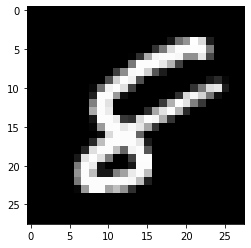

In [4]:
img_no=485
one_image=x_train[img_no]
plt.imshow(one_image,cmap='gist_gray')
print('Image label: {}'.format(y_train[img_no]))

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
x_train =x_train/255.0
x_train=x_train.reshape(-1,28,28,1)
y_train=tf.keras.utils.to_categorical(y_train,num_classes=10)

In [7]:
inputs_seq=tf.keras.layers.Input(shape=(28,28,1),name='MNIST_input')
dropout_rate=0.25

In [8]:
x=tf.keras.layers.Conv2D(32, kernel_size=5, padding='SAME', activation=tf.nn.relu)(inputs_seq)
x=tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x=tf.keras.layers.Conv2D(64, kernel_size=5, padding='SAME', activation=tf.nn.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024,activation=tf.nn.relu)(x)
x=tf.keras.layers.Dropout(dropout_rate)(x)
y=tf.keras.layers.Dense(10)(x)

In [9]:
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train,
                                                                     logits=y))
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [10]:
def build_bayesian_model(input_shape):
  tf.keras.backend.clear_session()
  model_in = tf.keras.layers.Input(shape=input_shape)
  conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3,3), padding="same", strides=2)
  x = conv_1(model_in)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3,3), padding="same", strides=2)
  x = conv_2(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Flatten()(x)
  dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
  x = dense_1(x)
  dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
  model_out = dense_2(x)  # logits
  model = tf.keras.Model(model_in, model_out)
  return model

In [11]:
@tf.function
def elbo_loss(labels,logits):
  loss_en=tf.nn.softmax_cross_entropy_with_logits(labels,logits)
  loss_kl=tf.keras.losses.KLD(labels, logits)
  loss=tf.reduce_mean(tf.add(loss_en, loss_kl))
  return loss

In [12]:
# @tf.function
# def elbo_loss(y_preds,y_train):
#   kl=sum(bayesian_model.losses)/len(x_train)
#   labels_distribution=tfp.distributions.Categorical(logits=y_preds)
#   neg_log_likelihood=-tf.reduce_mean(labels_distribution.log_prob(y_train))
#   return neg_log_likelihood+kl

In [13]:
@tf.function
def train_model(images,labels,model):
  with tf.GradientTape() as tape:
      logits=model(images)
      loss=elbo_loss(labels,logits)
  gradients=tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients,model.trainable_variables))
  return loss

def accuracy(preds, labels):
  return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))

In [14]:
bayesian_model=build_bayesian_model((28,28,1))
optimizer=tf.keras.optimizers.Adam(lr=0.01)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [15]:
! wget https://github.com/rahulremanan/python_tutorial/raw/master/Machine_Vision/07_Bayesian_deep_learning/weights/bayesianMNIST.h5 -O bayesianMNIST.h5
bayesian_model.load_weights('./bayesianMNIST.h5')

--2020-09-06 15:11:38--  https://github.com/rahulremanan/python_tutorial/raw/master/Machine_Vision/07_Bayesian_deep_learning/weights/bayesianMNIST.h5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/Machine_Vision/07_Bayesian_deep_learning/weights/bayesianMNIST.h5 [following]
--2020-09-06 15:11:39--  https://media.githubusercontent.com/media/rahulremanan/python_tutorial/master/Machine_Vision/07_Bayesian_deep_learning/weights/bayesianMNIST.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13071496 (12M) [application/octet-stream]
Saving to: ‘bayesian

In [16]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.3,random_state=42)

In [17]:
times=[]
accs=[]
val_accs=[]
losses=[]
val_losses=[]
for i in range(20):
  start=time.time()
  loss=train_model(x_train,y_train,bayesian_model)
  preds=bayesian_model(x_train)
  acc=accuracy(preds, y_train)
  accs.append(acc)
  losses.append(loss)
    
  val_preds=bayesian_model(x_val)
  val_loss=elbo_loss(y_val, val_preds)
  val_acc=accuracy(y_val, val_preds)
    
  val_accs.append(val_acc)
  val_losses.append(val_loss)
  end=time.time()
  train_time=end-start
  times.append(train_time)
    
  print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, val_loss = {:7.3f}, val_acc={:7.3f} time: {:7.3f}".format(i, loss, acc, val_loss, val_acc, train_time))

Epoch: 0: loss =   0.469 , accuracy =   0.585, val_loss =   1.819, val_acc=  0.589 time:  61.336
Epoch: 1: loss =   1.854 , accuracy =   0.854, val_loss =   0.483, val_acc=  0.851 time:  56.767
Epoch: 2: loss =   0.471 , accuracy =   0.779, val_loss =   0.724, val_acc=  0.774 time:  57.126
Epoch: 3: loss =   0.707 , accuracy =   0.770, val_loss =   0.755, val_acc=  0.767 time:  56.823
Epoch: 4: loss =   0.747 , accuracy =   0.773, val_loss =   0.730, val_acc=  0.771 time:  56.771
Epoch: 5: loss =   0.725 , accuracy =   0.808, val_loss =   0.648, val_acc=  0.805 time:  56.422
Epoch: 6: loss =   0.648 , accuracy =   0.856, val_loss =   0.520, val_acc=  0.851 time:  62.788
Epoch: 7: loss =   0.511 , accuracy =   0.883, val_loss =   0.417, val_acc=  0.883 time:  57.257
Epoch: 8: loss =   0.419 , accuracy =   0.892, val_loss =   0.380, val_acc=  0.893 time:  56.799
Epoch: 9: loss =   0.366 , accuracy =   0.897, val_loss =   0.359, val_acc=  0.897 time:  58.106
Epoch: 10: loss =   0.358 , ac

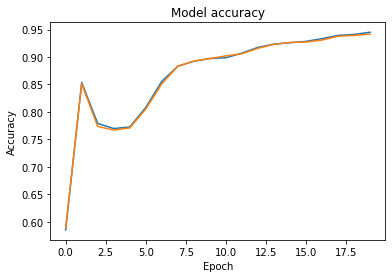

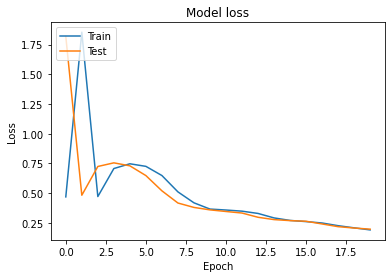

In [18]:
plt.plot(np.array(accs), label="acc")
plt.plot(np.array(val_accs), label="val_acc")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(np.array(losses), label="loss")
plt.plot(np.array(val_losses), label="val_loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
def plot_pred_hist(y_pred,n_class,n_mc_run,n_bins=30,med_prob_thres=0.2,n_subplot_rows=2,figsize=(25, 10)):
  bins = np.logspace(-n_bins, 0, n_bins+1)
  fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
  for i in range(n_subplot_rows):
    for j in range(n_class // n_subplot_rows + 1):
      idx = i * (n_class // n_subplot_rows + 1) + j
      if idx < n_class:
        ax[i, j].hist(y_pred[idx], bins)
        ax[i, j].set_xscale('log')
        ax[i, j].set_ylim([0, n_mc_run])
        ax[i, j].title.set_text("{} (median probability: {:.2f}) ({})".format(str(idx),
                                                                              np.median(y_pred[idx]),
                                                                              str(np.median(y_pred[idx]) >= med_prob_thres)))
      else:
        ax[i, j].axis('off')
  plt.show()

In [20]:
n_mc_run=50
med_prob_thres=0.35
y_pred_logits_list=[bayesian_model(x_val) for _ in tqdm(range(n_mc_run))]  # a list of predicted logits
y_pred_prob_all=np.concatenate([tf.nn.softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred=[[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred=np.array(y_pred)

100%|██████████| 50/50 [05:31<00:00,  6.63s/it]


In [21]:
idx_valid=[any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))
idx_invalid=[not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])
print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_val[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_val[idx_valid]))
print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_val[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_val[idx_invalid]))

Number of recognizable samples: 17915
Unrecognizable samples: [  248   463  1302  1394  1504  1537  1968  2291  2309  2325  2337  2454
  2546  3093  3176  3959  3997  4075  4116  4502  4674  4740  4761  5155
  5304  5728  5854  6004  6296  6356  6537  6586  6614  7036  7123  7502
  7628  7691  7784  7827  7834  8084  8197  8474  8656  8770  9023  9080
  9082  9085  9469  9883  9891 10004 10133 10209 10368 10645 10693 10910
 10964 11023 11039 11316 11479 11633 11783 11904 12169 12806 12829 12932
 13651 13737 14031 14461 14853 15584 16220 16581 16649 16799 16895 17687
 17883]
Test accuracy on MNIST (recognizable samples): 0.9540608428691041
Test accuracy on MNIST (unrecognizable samples): 0.058823529411764705


True label of the test sample 0: 7


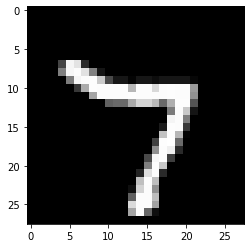

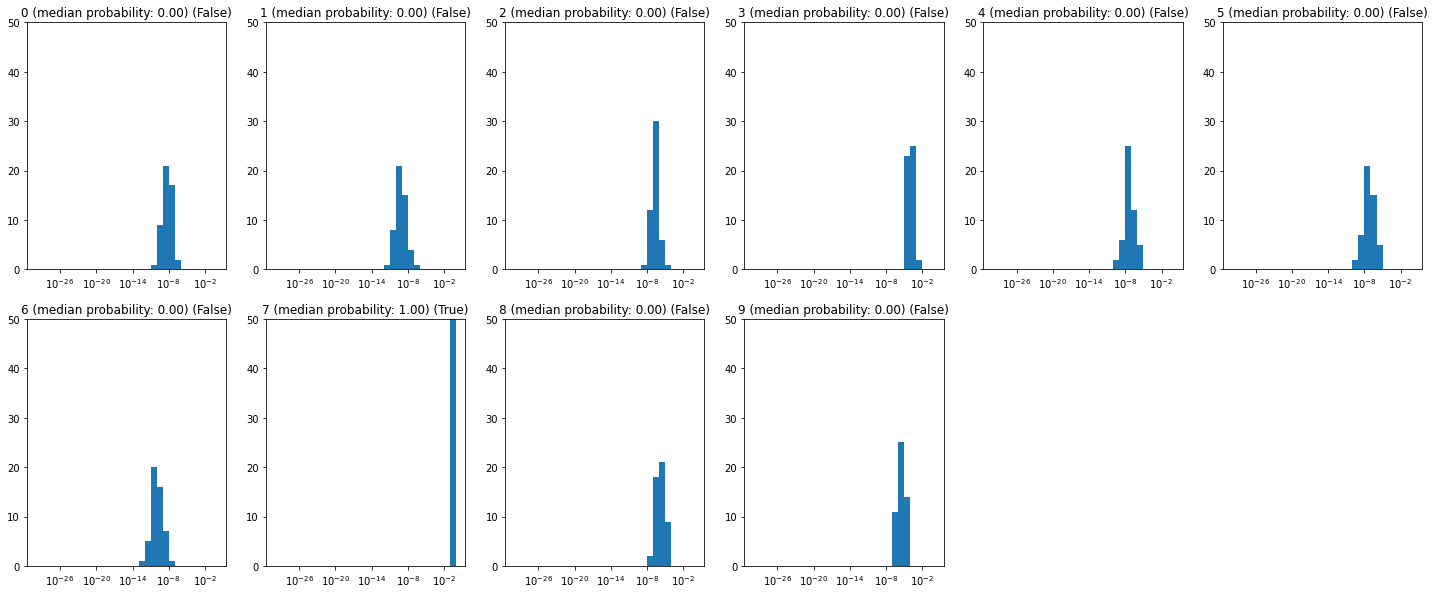

In [22]:
class_size=10
plt.imshow(x_val[0, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(0, np.argmax(y_val[0], axis=-1)))
plot_pred_hist(y_pred_prob_all[0], class_size, n_mc_run, med_prob_thres=med_prob_thres)

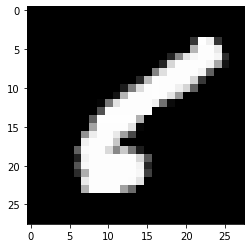

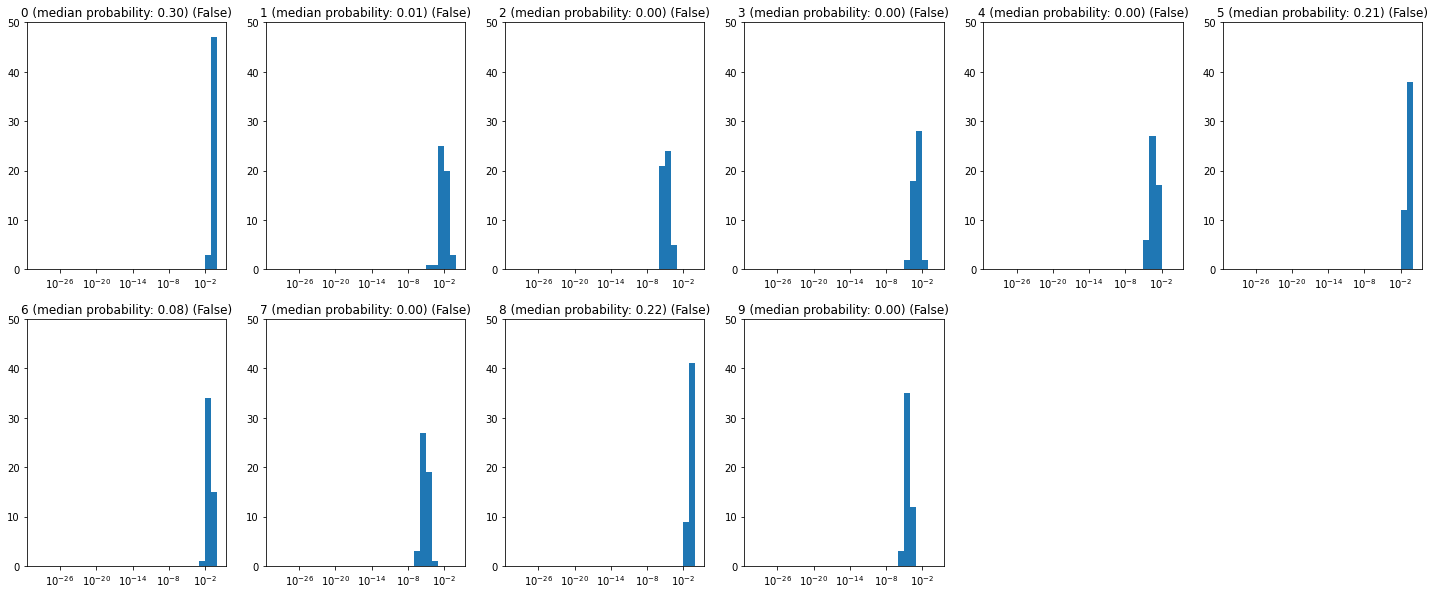

True label of test image 248: 6
High uncertainty in recognizing the image. Likely label: 0 ...




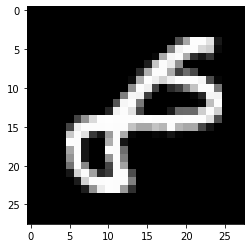

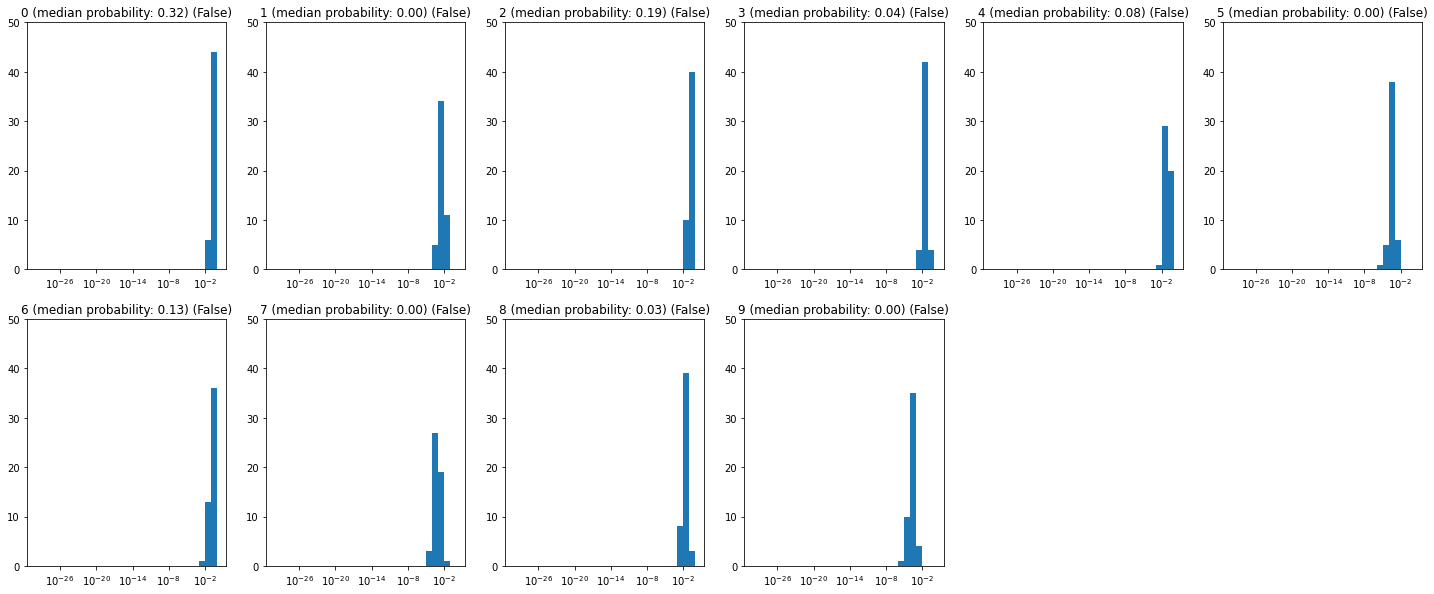

True label of test image 463: 8
High uncertainty in recognizing the image. Likely label: 0 ...




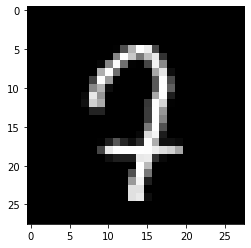

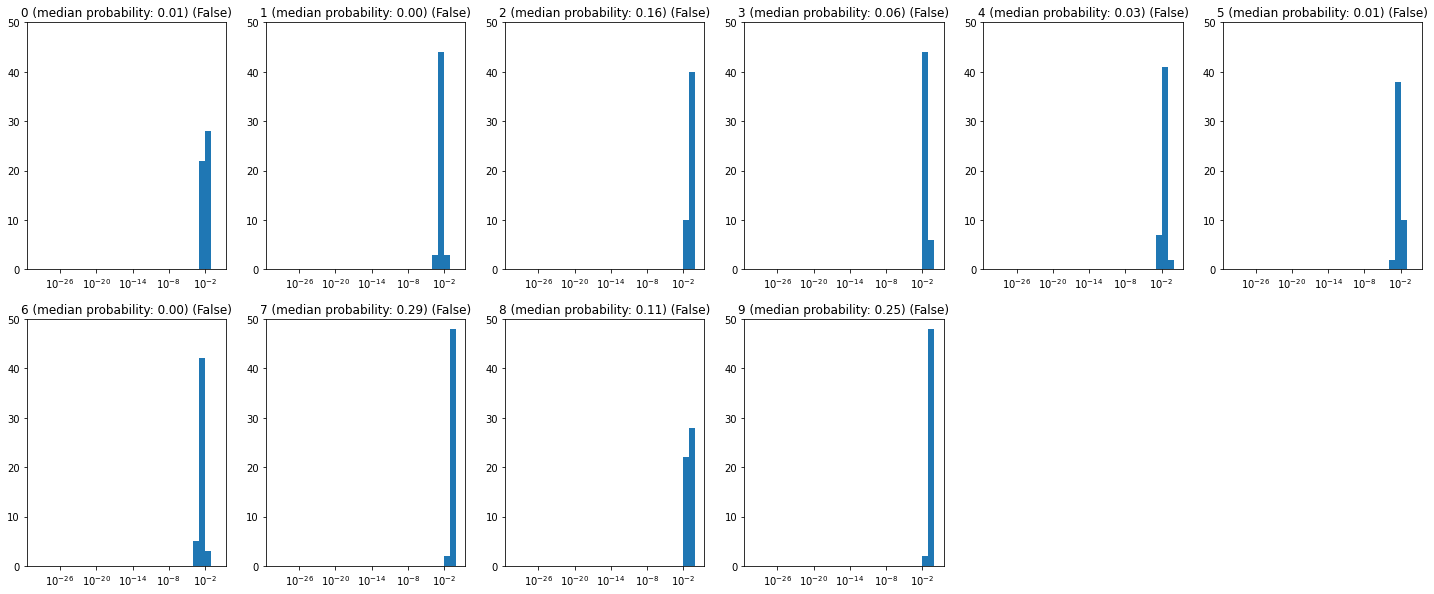

True label of test image 1302: 7
High uncertainty in recognizing the image. Likely label: 7 ...




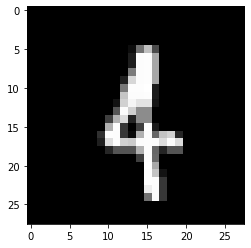

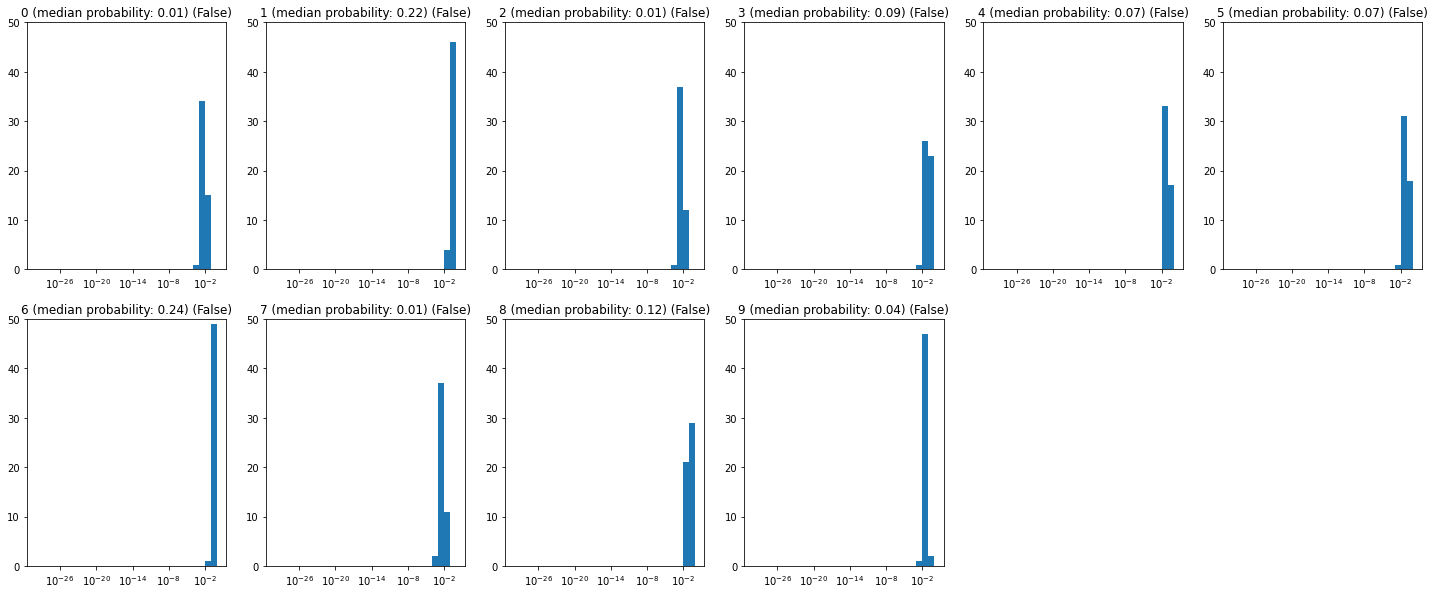

True label of test image 1394: 4
High uncertainty in recognizing the image. Likely label: 6 ...




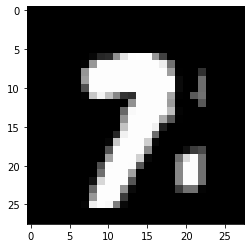

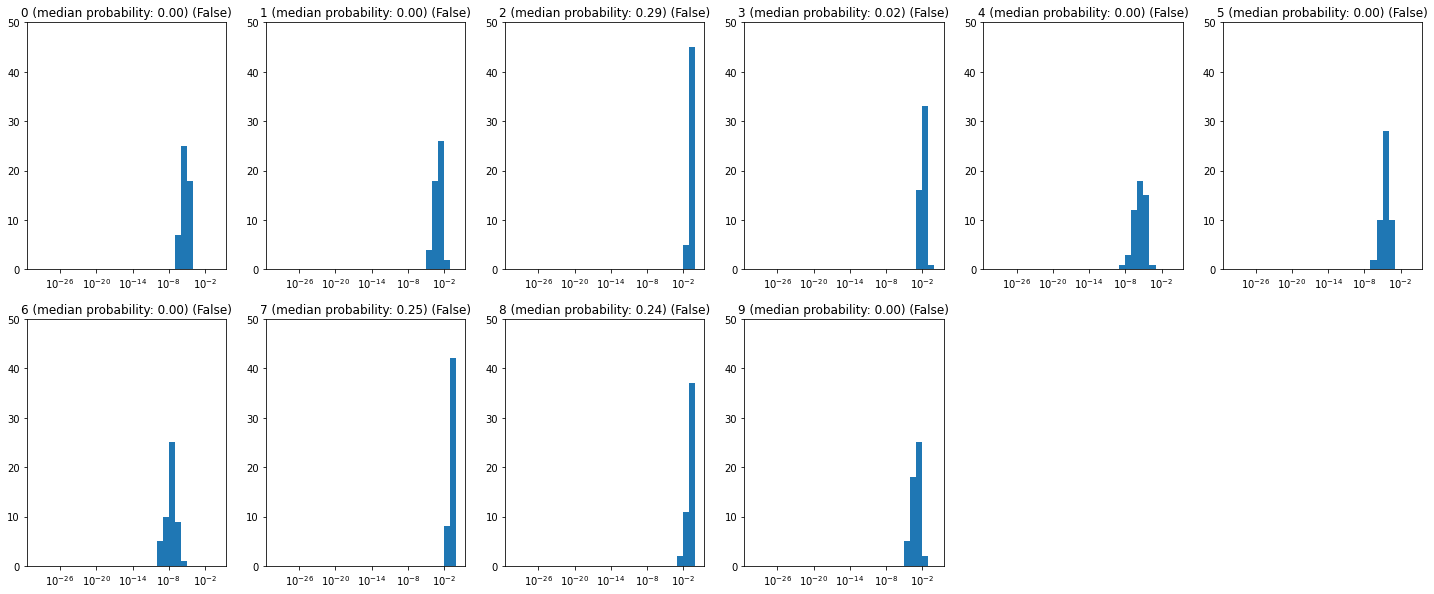

True label of test image 1504: 7
High uncertainty in recognizing the image. Likely label: 2 ...




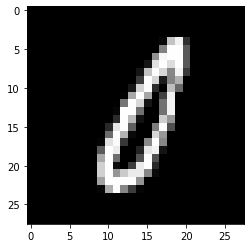

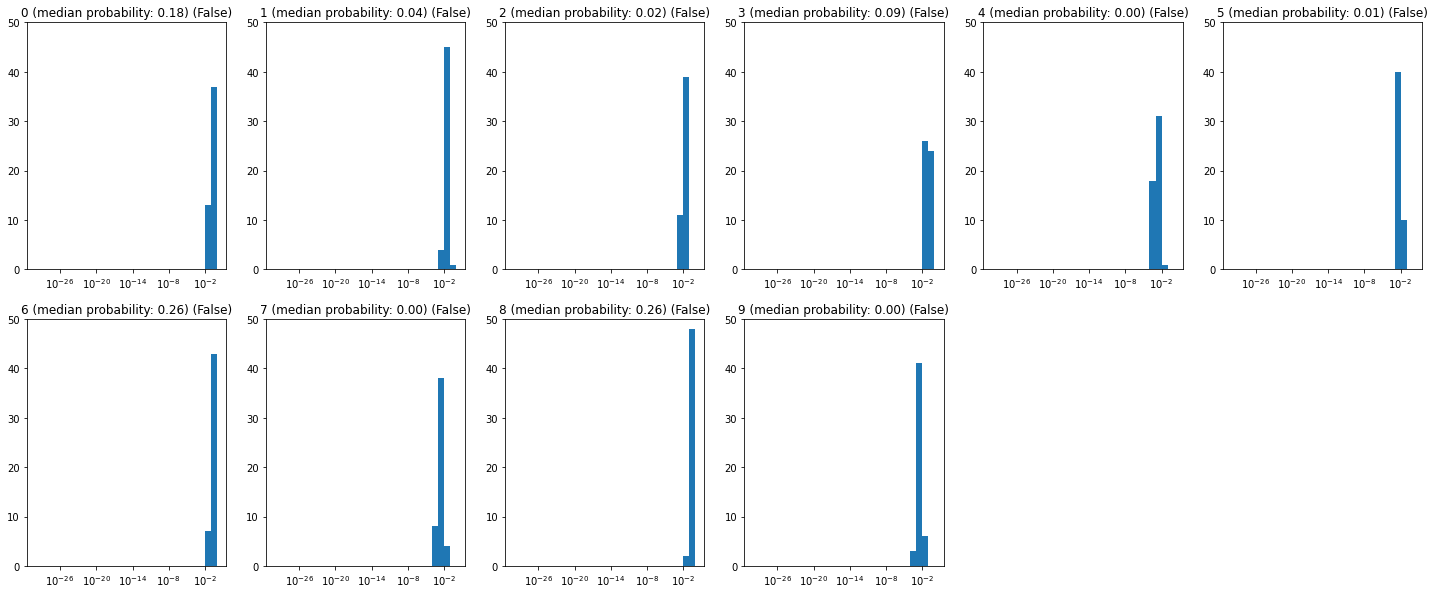

True label of test image 1537: 0
High uncertainty in recognizing the image. Likely label: 8 ...




In [23]:
class_size=10
num_invalids=0
for idx in np.where(idx_invalid)[0]:
  plt.imshow(x_val[idx,:,:,0],cmap='gist_gray')
  print('=============================================================================')
  plot_pred_hist(y_pred_prob_all[idx],class_size,n_mc_run,med_prob_thres=med_prob_thres)
  print("True label of test image {}: {}".format(idx,np.argmax(y_val[idx],axis=-1)))
  if any(y_pred[idx]):
    print("Predicted label of the test image {}: {}".format(idx,np.argmax(y_pred[idx],axis=-1)))
  else:
    print("High uncertainty in recognizing the image. Likely label: {} ...".format(np.argmax(np.mean(y_pred_prob_all[idx][:],axis=-1))))
    print('\n')
  num_invalids+=1
  if num_invalids > 5:
      break

In [24]:
bayesian_model.save_weights('bayesian_MNIST.h5')

# References:
1. [Medium post on Bayesian neural network using Tensorflow Probability](https://towardsdatascience.com/bayesian-neural-networks-with-tensorflow-probability-fbce27d6ef6#:~:text=%20Bayesian%20Neural%20Networks%20with%20TensorFlow%20Probability%20,the%20inputs%20and...%205%20Prediction.%20%20More%20)
2. [Kaggle kernel on Bayesian MNIST](https://www.kaggle.com/piesposito/bayesian-nerual-networks-with-tensorflow-2-0/notebook)